# The Obligatory MNIST Classifier (with a twist)
## *Goal: >99% accuracy without using XGBoost or Neural Networks*

This notebook focuses on creating a high-accuracy classifier with classical ML and good old-fashioned feature engineering / data preprocessing, hyperparameter optimization, and data augmentation.

### The MNIST Dataset

MNIST is a set of 70,000 images of small handwritten digits from high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents (remember, simple classification tasks are generally supervised learning).

Scikit-Learn comes with lots of utilities to help us easily download popular datasets like MNIST. Let's do that now.

In [158]:
from sklearn.datasets import fetch_openml
import joblib
from pathlib import Path

dataset_path = Path.cwd() / 'Datasets' / 'mnist.pkl'

# only fetch file if it hasn't been loaded previously
if not dataset_path.exists():
    mnist = fetch_openml('mnist_784', version=1)
    joblib.dump(mnist, dataset_path)

mnist = joblib.load(dataset_path)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

These keys follow the standard dictionary structure for Scikit-Learn datasets:
* a DESCR key describing the dataset
* a data key containing a 2D array with a row for each instance and a column for each feature
* a target key containing a 1D array with all the labels

Taking a look at these arrays can give us some insight into how we'll work with the data.

In [159]:
X, y = mnist['data'], mnist['target']
print('data array: ', X.shape, '\ntarget array: ', y.shape)

data array:  (70000, 784) 
target array:  (70000,)


We knew we were working with 70,000 images, but why does each instance have 784 features?

There are 784 features for each instance because each handwritten digit is represented by a 28x28 grid of grayscale pixels. Each feature is a value from 0 (white) to 255 (black). To see one of these images for ourselves, we'll just need to get the feature vector for some instance, reshape it into a 28x28 array, and use Matplotlib's imshow() function to display it.

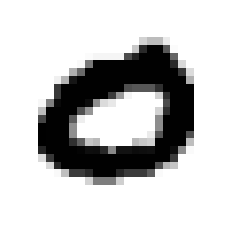

In [160]:
import matplotlib.pyplot as plt

def display_image_from_index(source, index):
    array = source.iloc[index].values
    image = array.reshape(28,28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    plt.show()

def display_image_from_row(source, row_index):
    if source[row_index, :, :].shape != (28, 28):
        image = source[row_index, :, :].reshape(28, 28)
    else:
        image = source[row_index, :, :]

    plt.imshow(image, cmap='binary')
    plt.axis('off')
    plt.show()

random_digit = 1995
display_image_from_index(X, random_digit)

That looks like a zero, which the label vector should confirm.

In [161]:
print(y.iloc[random_digit])

0


Awesome. Now let’s convert the labels from strings to integers.

In [162]:
import numpy as np

# convert label vector elements from str to int
y = y.astype(np.uint8)

Let's split our dataset up into training and test sets.

MNIST is actually already split for us - the first 60,000 are for training and the last 10,000 for testing. It's nice that the training set is already shuffled for us because it guarantees that all cross-validation folds will be similar (e.g., one fold isn't going to have tons of one digit and none of another). Also, some algorithms are sensitive to the order of the training instances, performing poorly if they get lots of similar instances in a row.

In [163]:
# Train/test split
X_train, X_test, y_train, y_test = X.iloc[:60000], X.iloc[60000:], y.iloc[:60000], y.iloc[60000:]

### A Basic Random Forest Classifier
Let's see how sklearn's RandomForestClassifier works right out of the box.

In [164]:
from sklearn.ensemble import RandomForestClassifier

model_dir = Path.cwd() / 'Models'
basic_rfc_path = model_dir / 'basic_rfc.pkl'

if not basic_rfc_path.exists():
    basic_rfc = RandomForestClassifier()
    basic_rfc.fit(X_train, y_train)
    joblib.dump(basic_rfc, basic_rfc_path)
else:
    basic_rfc = joblib.load(basic_rfc_path)

In [165]:
import statistics
from sklearn.model_selection import cross_val_score

# display accuracy score
metrics_dir = Path.cwd() / 'Metrics'
basic_rfc_acc_path = metrics_dir / 'basic_rfc_acc.pkl'

if not basic_rfc_acc_path.exists():
    rfc_accuracy = cross_val_score(basic_rfc, X_train, y_train, cv=3, scoring='accuracy')
    joblib.dump(rfc_accuracy, basic_rfc_acc_path)
else:
    rfc_accuracy = joblib.load(basic_rfc_acc_path)

print('RFC Accuracy: '+str(rfc_accuracy), "Average: "+str(statistics.mean(rfc_accuracy)).format('.2%'), sep='\n')

RFC Accuracy: [0.96515 0.96355 0.96785]
Average: 0.9655166666666667


### Error Analysis

Without a single adjustment, the random forest classifier is already performing quite well, but the goal is to reach the elusive 99% mark. Let's start by plotting a confusion matrix to see where the basic model struggles.

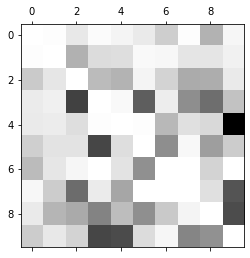

In [166]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# compute confusion matrix
y_train_pred = cross_val_predict(basic_rfc, X_train, y_train, cv=3)
rfc_cm = confusion_matrix(y_train, y_train_pred)

# create function to convert error counts to error rates
def conf_mx_count_to_rate(count_mx):
    # convert to error rate from count
    sum_rows = count_mx.sum(axis=1, keepdims=True)
    norm_mx = count_mx / sum_rows
    # fill diagonal with zeros to focus only on errors
    np.fill_diagonal(norm_mx, 0)

    return norm_mx

# call function
norm_conf_mx = conf_mx_count_to_rate(rfc_cm)

# show plot
plt.matshow(norm_conf_mx, cmap=plt.cm.gray_r)
plt.show()

Unlike the confusion matrix from the chapter demonstration, there are no standout rows or columns indicating that the majority of the errors are coming from one specific type of error. However, there are some interesting insights to gather:
* the two brightest squares are 4s confused for 9s and 3s confused for 2s - both things that we could potentially help with some feature engineering, like an algorithm to count the number of closed loops in an image, or return the center of mass for an image.
* 8s and 9s seem to be particularly difficult for the classifier to get right.
* 0s and 1s seem to be relatively easy to identify

### Data Preprocessing
Let's start by adding some preprocessing steps to the basic classifier:

  1.) add a 'number of closed loops' feature to each instance (and one hot encode it since it's such a low-cardinality feature it's practically categorical)
  2.) make each digit more uniform by cropping the grid then scaling each axis to return an (n x n) grid
  3.) add a center of mass feature for each axis
  4.) use the StandardScaler() transformer to apply standardization to all features

In [167]:
# LOOP ADDER

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# define a function to return count of closed loops in image
def get_closed_loop_count(image_1d, empty_threshold=0, side_length=28):
    if not isinstance(image_1d, np.ndarray):
        image_1d = np.array(image_1d)
    if not image_1d.shape == (side_length, side_length):
        image_1d = image_1d.reshape(side_length, side_length)

    image_2d = image_1d

    empties = (image_2d <= empty_threshold)

    # traverse empties recursively
    def traverse_empties(start_row, start_col, array):
        array[start_row, start_col] = False
        if start_row+1 < array.shape[0] and array[start_row+1, start_col]:
            traverse_empties(start_row+1, start_col, array)
        if start_col+1 < array.shape[1] and array[start_row, start_col+1]:
            traverse_empties(start_row, start_col+1, array)
        if start_row-1 >= 0 and array[start_row-1, start_col]:
            traverse_empties(start_row-1, start_col, array)
        if start_col-1 >= 0 and array[start_row, start_col-1]:
            traverse_empties(start_row, start_col-1, array)
        return

    # exhaust the first cluster of empty pixels, increment cluster_count, then check for more empty pixels and repeat until all empties are exhausted.
    cluster_count = 0
    while np.any(empties):
        first_empty_index = (np.where(empties)[0][0], np.where(empties)[1][0])
        traverse_empties(first_empty_index[0], first_empty_index[1], empties)
        cluster_count += 1

    # outside space should not be counted as a loop
    loop_count = cluster_count - 1

    loop_count = str(loop_count)
    if int(loop_count) > 2:
        loop_count = 'invalid'

    return loop_count

# wrap that function in a custom sklearn transformer
class LoopCountCatAdder(BaseEstimator, TransformerMixin):
    def __init__(self, empty_threshold=125, side_length=28, one_hot=True):
        self.empty_threshold = empty_threshold
        self.side_length = side_length
        self.one_hot = one_hot
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        loop_counts = []
        for array in X:
            loop_counts.append(get_closed_loop_count(array.reshape(self.side_length, self.side_length), empty_threshold=self.empty_threshold))
        if self.one_hot:
            ohe = OneHotEncoder(sparse=False, categories=[['0', '1', '2', 'invalid']])
            loop_counts = ohe.fit_transform(np.array(loop_counts).reshape(-1, 1))
        else:
            le = LabelEncoder()
            le.fit(['0', '1', '2', 'invalid'])
            loop_counts = le.transform(np.array(loop_counts))

        return np.c_[X, loop_counts]

In [168]:
# CROP AND FITTER

from scipy.ndimage.interpolation import zoom

# define another custom transformer to handle making the images more uniform
class CropAndFitter(BaseEstimator, TransformerMixin):
    def __init__(self, zero_threshold=10, result_size=13, max_zoom=None):
        self.zero_threshold = zero_threshold
        self.result_size = result_size
        self.max_zoom  = max_zoom
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # eliminate df/ndarray issues
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        # slice only the pixel value columns (no extracted features like loop count)
        X_pixel_cols = X[:, :784]
        X_other_cols = X[:, 784:]

        # reshape X to n_instances,28,28
        X_reshaped = X_pixel_cols.reshape(X.shape[0], 28, 28)

        # values below the zero_threshold are set to zero
        X_reshaped[X_reshaped < self.zero_threshold] = 0

        # crop each 28x28 grid by finding the first row or column with a sum > 0 (from all four sides)
        # then zoom each axis of the grid to make it a square of side length specified in constructor
        list_of_transformed_grids = []
        count = 0
        for grid in X_reshaped:
            assert grid.shape == (28, 28), 'grids are not 28x28 like you thought.'
            col_sums = np.sum(grid, axis=0)
            row_sums = np.sum(grid, axis=1)
            l, r = int(np.argwhere(col_sums > 0)[0]), int(np.argwhere(col_sums > 0)[-1])
            t, b = int(np.argwhere(row_sums > 0)[0]), int(np.argwhere(row_sums > 0)[-1])

            if not r - l > 0:
                r += 1
                l -= 1
            if not b - t > 0:
                b += 1
                t -= 1

            grid = grid[t:b, l:r]

            if self.max_zoom:
                length = grid.shape[0]
                width = grid.shape[1]
                ratio = length / width

                while ratio > self.max_zoom:
                    grid = np.pad(grid, [(0, 0), (1, 1)], mode='constant')
                    length = grid.shape[0]
                    width = grid.shape[1]
                    ratio = length / width
                while ratio < 1 / self.max_zoom:
                    grid = np.pad(grid, [(1, 1), (0, 0)], mode='constant')
                    length = grid.shape[0]
                    width = grid.shape[1]
                    ratio = length / width

            y_zoom_factor = self.result_size / grid.shape[0]
            x_zoom_factor = self.result_size / grid.shape[1]

            grid = zoom(grid, (y_zoom_factor, x_zoom_factor))
            grid[grid < 10] = 0

            assert grid.shape == (self.result_size, self.result_size), 'zoomed grid not the right shape'

            # because of the way spline interpolation works, straight vertical lines will sometimes
            # totally disappear when scaled down, so we just recreate a standard "one" shape
            if np.sum(grid) == 0:
                grid = np.zeros((self.result_size, self.result_size))
                grid[:, 6] = 255
            list_of_transformed_grids.append(grid)
            count += 1

        list_as_array = np.array(list_of_transformed_grids)

        # flatten grids and tack the non-pixel columns back on before returning
        return np.c_[list_as_array.reshape(list_as_array.shape[0], -1), X_other_cols]

In [169]:
# CENTER OF MASS ADDER

from scipy.ndimage import center_of_mass

# create a transformer to add center of mass features (one for each axis)
class CenterOfMassAdder(BaseEstimator, TransformerMixin):
    def __init__(self, expected_side_len=13):
        self.expected_side_len = expected_side_len
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        sl = self.expected_side_len

        # slice just the pixel columns
        end_index = sl**2
        X_pixel_cols = X[:, :end_index]

        # reshape X to n_instances,sl,sl
        X_reshaped = X_pixel_cols.reshape(X.shape[0], sl, sl)

        # get center of mass for each grid
        two_new_feature_vectors = []
        for grid in X_reshaped:
            two_new_feature_vectors.append(center_of_mass(grid))

        # convert to ratio if necessary
        mapped_vectors = []
        for t in two_new_feature_vectors:
            m = ((t[0]/sl)*255, (t[1]/sl)*255)
            mapped_vectors.append(m)

        assert len(mapped_vectors) == X_reshaped.shape[0], 'center of mass feature vectors wrong length'

        # add new features
        mapped_vectors = np.array(mapped_vectors)
        with_features = np.c_[X, mapped_vectors]

        return with_features

With our custom transformers ready to go, we can now consolidate everything (including the classifier itself) into a single pipeline. This will serve as our new and improved model (now with data preprocessing and feature extraction!).

Let's put it all together and see if our validation accuracy improves!

In [170]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# incorporate preprocessing steps into pipeline with classifier
rfc_with_pp = Pipeline([
    ('loop_count_adder', LoopCountCatAdder()),
    ('crop_and_fitter', CropAndFitter()),
    ('com_adder', CenterOfMassAdder()),
    ('scaler', StandardScaler()),
    ('rfc', RandomForestClassifier())
])

In [171]:
# display accuracy score
rfc_with_pp_acc_path = metrics_dir / 'rfc_with_pp_acc.pkl'

if not rfc_with_pp_acc_path.exists():
    accuracy = cross_val_score(rfc_with_pp, X_train, y_train, cv=3, scoring='accuracy')
    joblib.dump(accuracy, rfc_with_pp_acc_path)
else:
    accuracy = joblib.load(rfc_with_pp_acc_path)

print('Accuracy: '+str(accuracy), "Average: "+str(statistics.mean(accuracy)), sep='\n')

Accuracy: [0.96795 0.9691  0.96945]
Average: 0.9688333333333333


A very modest gain of about 0.33%.

As you may have noticed, however, there are a few hyperparameters built into the custom transformers we just defined, and we haven't even touched the RandomForestClassifier hyperparameters yet, so there is still quite a bit of optimization left to perform before we call it quits.

But before we move on to hyperparameter optimization, let's augment our dataset.

### Data Augmentation

By making slight alterations to instances from our existing dataset, we can artificially increase the size of the training set to help our model with generalization. A common augmentation technique for the MNIST dataset is shifting the images slightly either vertically or horizontally, but our CropAndFitter() transformer should theoretically eliminate these shifts anyway, making the change redundant. Instead, we can use a function from the scipy.ndimage module to rotate the images slightly and add these altered copies to the dataset.

In [172]:
# ROTATION AUGMENTATION

from scipy.ndimage import rotate

# define transformer to triple the datset size by adding instances rotated clockwise and counterclockwise
class RotationAug(BaseEstimator, TransformerMixin):
    def __init__(self, rotation_angle=10.0):
        self.rotation_angle = rotation_angle
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        ra = self.rotation_angle

        X_reshaped = np.array(X).reshape(X.shape[0], 28, 28)

        XR1 = rotate(X_reshaped[0::3, :, :], ra * -0.33, reshape=False, axes=(1,2))
        XR2 = rotate(X_reshaped[1::3, :, :], ra * -0.66, reshape=False, axes=(1,2))
        XR3 = rotate(X_reshaped[2::3, :, :], ra * -1, reshape=False, axes=(1,2))
        XR4 = rotate(X_reshaped[2::3, :, :], ra * -0.17, reshape=False, axes=(1,2))
        XR5 = rotate(X_reshaped[1::3, :, :], ra * -0.40, reshape=False, axes=(1,2))
        XR6 = rotate(X_reshaped[0::3, :, :], ra * -0.83, reshape=False, axes=(1,2))
        R_combo = np.concatenate((XR1, XR2, XR3, XR4, XR5, XR6), axis=0)

        XL1 = rotate(X_reshaped[0::3, :, :], ra * 0.33, reshape=False, axes=(1,2))
        XL2 = rotate(X_reshaped[1::3, :, :], ra * 0.66, reshape=False, axes=(1,2))
        XL3 = rotate(X_reshaped[2::3, :, :], ra, reshape=False, axes=(1,2))
        XL4 = rotate(X_reshaped[2::3, :, :], ra * 0.17, reshape=False, axes=(1,2))
        XL5 = rotate(X_reshaped[1::3, :, :], ra * 0.40, reshape=False, axes=(1,2))
        XL6 = rotate(X_reshaped[0::3, :, :], ra * 0.83, reshape=False, axes=(1,2))
        L_combo = np.concatenate((XL1, XL2, XL3, XL4, XL5, XL6), axis=0)

        X_combo = np.concatenate((X_reshaped, R_combo, L_combo), axis=0)

        # remove artifacts from spline interpolation
        X_combo[X_combo < 12] = 0

        return X_combo.reshape(X_combo.shape[0], -1)

Since the resulting dataset will be split by rotation, we'll need to shuffle the data to ensure the decision trees composing our random forest aren't disproportionately fit to some rotation. It's a bit difficult to add y-transformations to custom sklearn transformers, so we'll just make it a disposable function.

In [173]:
from sklearn.utils import shuffle

# define a function to augment and shuffle X and y together
def aug_rotate_shuffle(X, y, rotation_angle=15):
    r = RotationAug(rotation_angle=rotation_angle)
    X_unshuffled = r.transform(X)

    y_stage1 = np.concatenate((y[0::3], y[1::3], y[2::3], y[2::3], y[1::3], y[0::3]), axis=0)
    y_unshuffled = np.concatenate((y, np.tile(y_stage1, 2)), axis=0)

    X_shuffled, y_shuffled = shuffle(X_unshuffled, y_unshuffled)

    return X_shuffled, y_shuffled

In [174]:
# call function to get augmented dataset
X_aug, y_aug = aug_rotate_shuffle(np.array(X_train), np.array(y_train))

# check shapes
print(X_aug.shape)
print(y_aug.shape)

(300000, 784)
(300000,)


Before moving on to hyperparameter optimization, let's see how the new dataset affects our validation performance.

In [175]:
# display accuracy score
rfc_pp_aug_acc_path = metrics_dir / 'rfc_pp_aug_acc.pkl'

if not rfc_pp_aug_acc_path.exists():
    accuracy = cross_val_score(rfc_with_pp, X_aug, y_aug, cv=3, scoring='accuracy')
    joblib.dump(accuracy, rfc_pp_aug_acc_path)
else:
    accuracy = joblib.load(rfc_pp_aug_acc_path)

print('Accuracy: '+str(accuracy), "Average: "+str(statistics.mean(accuracy)), sep='\n')

Accuracy: [0.9747  0.97455 0.9748 ]
Average: 0.9746833333333333


### Hyperparameter Optimization

Treating our pipeline like a self-contained model gives us the ability to do a parameter search for each step of the preprocessing stage in addition to the hyperparameters built into the RandomForestClassifier class - a huge advantage.

Because we have a pretty decent number of hyperparameters to optimize, it would be a good idea to use sklearn's' HalvingGridSearch class in place of the normal GridSearch class. HalvingGridSearch essentially hosts a tournament between each possible combination, but using tiny subsets of data for the initial rounds and increasing the number of resources as the number of contenders decreases. The resulting search still takes a while, but it's about an order of magnitude quicker than the regular GridSearch.

In [176]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# if we haven't searched already
rfc_path = Path.cwd() / 'Models' / 'rfc.pkl'
if not rfc_path.exists():

    # define the param combos to test
    params =  {'loop_count_adder__empty_threshold': [125],
               'crop_and_fitter__zero_threshold': [10],
               'crop_and_fitter__result_size': [13],
               'rfc__bootstrap': [False],
               'rfc__max_depth': [20, 25, 30],
               'rfc__max_features': ['auto'],
               'rfc__min_samples_leaf': [1],
               'rfc__min_samples_split': [2],
               'rfc__n_estimators': [500],
               'com_adder__expected_side_len': [13]}

    # conduct the search
    halving_grid_search = HalvingGridSearchCV(rfc_with_pp, params, scoring='accuracy', min_resources='exhaust', factor=3, n_jobs=-1, verbose=5, cv=3)
    halving_grid_search.fit(X_aug[:10000], y_aug[:10000])

    # save the winning estimator
    rfc = halving_grid_search.best_estimator_
    joblib.dump(rfc, rfc_path)

    # print best params
    print(halving_grid_search.best_params_)

In [178]:
from sklearn.metrics import accuracy_score

if not rfc_path.exists():
    rfc = halving_grid_search.best_estimator_
else:
    rfc = joblib.load(rfc_path)

rfc.fit(X_train, y_train)

accuracy = accuracy_score(y_test, rfc.predict(X_test))
print(format(float(accuracy), '.2%'))

97.87%


This is a significant improvement over the basic RandomForestClassifier and a pretty good accuracy score for a classical ML model on this kind of problem! However, we still have some work to do if we're going to achieve 99%. Let's start by plotting another confusion matrix, but this time we'll subtract the errors of our new classifier from the errors of our old classifier. This way, we'll be able to see where our model has improved or fallen behind because of our modifications.

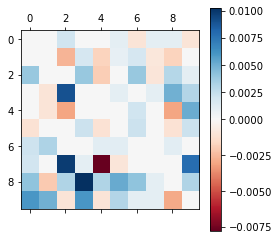

In [179]:
from matplotlib.colors import TwoSlopeNorm

# compute confusion matrix
rfc_cm = confusion_matrix(y_test, rfc.predict(X_test))
basic_rfc_cm = confusion_matrix(y_test, basic_rfc.predict(X_test))

# call function
norm_conf_mx = conf_mx_count_to_rate(rfc_cm)
basic_norm_conf_mx = conf_mx_count_to_rate(basic_rfc_cm)

improvement_matrix = np.subtract(basic_norm_conf_mx, norm_conf_mx)

# show plot
plt.matshow(improvement_matrix, norm=TwoSlopeNorm(0), cmap=plt.cm.RdBu, interpolation=None)
plt.colorbar()
plt.show()

In the plot above, blue squares represent areas of improvement, and red squares represent areas of regression (no pun intended). We can see that the modifications have hurt the model's ability to distinguish 8s from 1s. This actually makes sense; when the scale/crop transformer comes across a one (a thin vertical line), it stretches it out until it's essentially a square blob. This would look very similar to an 8 that has gone through the same transformation. Let's try setting a maximum "stretch" value for the scale/crop transformer to attempt to rectify this problem.

In addition, let's add a couple more layer of uniformity to the preprocessing pipeline: a skeletonizer and a rotator! The skeletonizer will convert the images to binary representations just one pixel wide. Hopefully, this will reduce uncertainty due to the varying thicknesses of digits written by different people. Similarly, the rotator will attempt to reduce the rotational variation in digits by plotting the skeletonized pixels in a cartesian graph, finding the slope of the best fit line, and rotating the actual image by the angle the best fit line makes with an imaginary vertical line.

In [154]:
# CUSTOM TRANSFORMER - SKELETONIZER

from skimage.morphology import skeletonize, medial_axis

class Skeletonizer(BaseEstimator, TransformerMixin):
    def __init__(self, use=True, binary_threshold=0, medial_axis=False, expected_side_len=13):
        self.use = use
        self.binary_threshold = binary_threshold
        self.medial_axis = medial_axis
        self.expected_side_len = expected_side_len
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.use:
            sl = self.expected_side_len
            X_image, X_info = X[:, :sl**2], X[:, sl**2:]

            skeletonized_grids = []

            if not self.medial_axis:
                for row in X_image:
                    skeletonized_grids.append(skeletonize((row.reshape(sl, sl) > 0)))
            else:
                for row in X_image:
                    skeletonized_grids.append(medial_axis((row.reshape(sl, sl) > 0)))

            X_ibr = np.array(skeletonized_grids).reshape(len(skeletonized_grids), -1)
            X = np.c_[X_ibr, X_info]

        return X

In [155]:
# CUSTOM TRANSFORMER - ROTATOR

from scipy.stats import linregress
import math

class RotationFixer(BaseEstimator, TransformerMixin):
    def __init__(self, use=True, binary_threshold=10):
        self.use = use
        self.binary_threshold = binary_threshold
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if self.use:
            X_img, X_info = X[:, :784], X[:, 784:]
            X_r = X_img.reshape(X.shape[0], 28, 28)
            rotated_grid_list = []
            for grid in X_r:
                x, y = np.argwhere(grid > self.binary_threshold).T
                result = linregress(x, y)
                slope = result.slope
                angle = math.degrees(math.atan(slope))
                offset = 0 - angle
                rotated_grid_list.append(rotate(grid, offset, reshape=False))
            X = np.array(rotated_grid_list).reshape(len(rotated_grid_list), -1)
            X[X < self.binary_threshold] = 0
            X = np.c_[X, X_info]

        return X

starting grid 0
starting grid 1
starting grid 2
starting grid 3
starting grid 4
starting grid 5
starting grid 6
starting grid 7
starting grid 8
starting grid 9
starting grid 10
starting grid 11
starting grid 12
starting grid 13
starting grid 14
starting grid 15
starting grid 16
starting grid 17
starting grid 18
starting grid 19
starting grid 20
starting grid 21
starting grid 22
starting grid 23
starting grid 24
starting grid 25
starting grid 26
starting grid 27
starting grid 28
starting grid 29
starting grid 30
starting grid 31
starting grid 32
starting grid 33
starting grid 34
starting grid 35
starting grid 36
starting grid 37
starting grid 38
starting grid 39
starting grid 40
starting grid 41
starting grid 42
starting grid 43
starting grid 44
starting grid 45
starting grid 46
starting grid 47
starting grid 48
starting grid 49
starting grid 50
starting grid 51
starting grid 52
starting grid 53
starting grid 54
starting grid 55
starting grid 56
starting grid 57
starting grid 58
startin

Pipeline(steps=[('loop_count_adder', LoopCountCatAdder(empty_threshold=125)),
                ('rotation_fixer', RotationFixer()),
                ('skeletonizer', Skeletonizer(binary_threshold=10)),
                ('crop_and_fitter',
                 CropAndFitter(max_zoom=1.5, result_size=28, zero_threshold=0)),
                ('com_adder', CenterOfMassAdder(expected_side_len=28)),
                ('rfc',
                 RandomForestClassifier(bootstrap=False, max_depth=25,
                                        n_jobs=-1))])

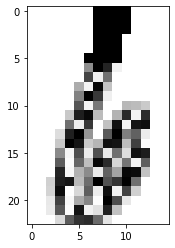

In [112]:
# create a new classifier out of a pipeline with the skeletonizer added
rfc2 = Pipeline([('loop_count_adder', LoopCountCatAdder(empty_threshold=125)),
                 ('rotation_fixer', RotationFixer()),
                 ('skeletonizer', Skeletonizer(binary_threshold=10)),
                 ('crop_and_fitter', CropAndFitter(zero_threshold=0, result_size=28, max_zoom=1.5)),
                 ('com_adder', CenterOfMassAdder(expected_side_len=28)),
                 ('rfc', RandomForestClassifier(n_jobs=-1, bootstrap=False, max_depth=25, max_features='auto', min_samples_leaf=1, min_samples_split=2, n_estimators=100))])

rfc2.fit(X_train[:1000], y_train[:1000])

starting grid 0
starting grid 1
starting grid 2
starting grid 3
starting grid 4
starting grid 5
starting grid 6
starting grid 7
starting grid 8
starting grid 9
starting grid 10
starting grid 11
starting grid 12
starting grid 13
starting grid 14
starting grid 15
starting grid 16
starting grid 17
starting grid 18
starting grid 19
starting grid 20
starting grid 21
starting grid 22
starting grid 23
starting grid 24
starting grid 25
starting grid 26
starting grid 27
starting grid 28
starting grid 29
starting grid 30
starting grid 31
starting grid 32
starting grid 33
starting grid 34
starting grid 35
starting grid 36
starting grid 37
starting grid 38
starting grid 39
starting grid 40
starting grid 41
starting grid 42
starting grid 43
starting grid 44
starting grid 45
starting grid 46
starting grid 47
starting grid 48
starting grid 49
starting grid 50
starting grid 51
starting grid 52
starting grid 53
starting grid 54
starting grid 55
starting grid 56
starting grid 57
starting grid 58
startin

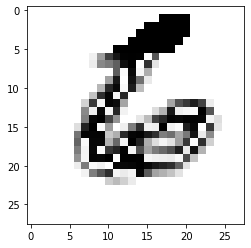

In [110]:
accuracy = accuracy_score(y_test, rfc2.predict(X_test))
print(format(float(accuracy), '.2%'))

(10, 788)
[  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0

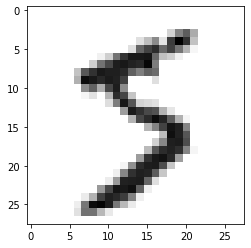

In [157]:
l = LoopCountCatAdder()
r = RotationFixer()
s = Skeletonizer()
c = CropAndFitter()
com = CenterOfMassAdder()

t = r.transform(l.transform(X_train[:10]))
#t = s.transform(t)
print(t.shape)
print(t[0])
plt.imshow(t[0, :784].reshape(28,28), cmap='binary')

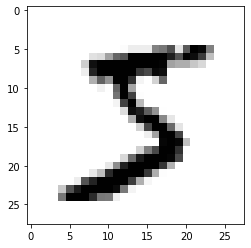

In [153]:
plt.imshow(np.array(X_train)[0].reshape(28,28), cmap='binary')

In [31]:
# create the parameter grid
param_grid = [
    {'loop_count_adder__empty_threshold': [125],
     'skeletonizer__use': [True, False],
     'skeletonizer__binary_threshold': [0, 10, 100],
     'skeletonizer__medial_axis': [True, False],
     'crop_and_fitter__zero_threshold': [0, 10, 100],
     'crop_and_fitter__result_size': [12],
     'crop_and_fitter__max_zoom': [None, 1.5, 2, 3],
     'com_adder__expected_side_len': [12],
     'com_adder__as_ratio': [True, False],
     'rfc__n_jobs': [-1],
     'rfc__bootstrap': [False],
     'rfc__max_depth': [25],
     'rfc__max_features': ['auto'],
     'rfc__min_samples_leaf': [1],
     'rfc__min_samples_split': [2],
     'rfc__n_estimators': [100]},

    {'loop_count_adder__empty_threshold': [125],
     'skeletonizer__use': [True, False],
     'skeletonizer__binary_threshold': [0, 10, 100],
     'skeletonizer__medial_axis': [True, False],
     'crop_and_fitter__zero_threshold': [0, 10, 100],
     'crop_and_fitter__result_size': [13],
     'crop_and_fitter__max_zoom': [None, 1.5, 2, 3],
     'com_adder__expected_side_len': [13],
     'com_adder__as_ratio': [True, False],
     'rfc__n_jobs': [-1],
     'rfc__bootstrap': [False],
     'rfc__max_depth': [25],
     'rfc__max_features': ['auto'],
     'rfc__min_samples_leaf': [1],
     'rfc__min_samples_split': [2],
     'rfc__n_estimators': [100]},

    {'loop_count_adder__empty_threshold': [125],
     'skeletonizer__use': [True, False],
     'skeletonizer__binary_threshold': [0, 10, 100],
     'skeletonizer__medial_axis': [True, False],
     'crop_and_fitter__zero_threshold': [0, 10, 100],
     'crop_and_fitter__result_size': [14],
     'crop_and_fitter__max_zoom': [None, 1.5, 2, 3],
     'com_adder__expected_side_len': [14],
     'com_adder__as_ratio': [True, False],
     'rfc__n_jobs': [-1],
     'rfc__bootstrap': [False],
     'rfc__max_depth': [25],
     'rfc__max_features': ['auto'],
     'rfc__min_samples_leaf': [1],
     'rfc__min_samples_split': [2],
     'rfc__n_estimators': [100]}
]

# conduct the search
halving_grid_search = HalvingGridSearchCV(rfc2, param_grid, scoring='accuracy', min_resources='exhaust', factor=3, n_jobs=-1, verbose=2, cv=3, refit=False)
halving_grid_search.fit(X_train[:50000], y_train[:50000])

# save the winning estimator
rfc = halving_grid_search.best_estimator_

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 68
max_resources_: 50000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 864
n_resources: 68
Fitting 3 folds for each of 864 candidates, totalling 2592 fits


C:\Users\steve\anaconda3\envs\data_spell_env\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1296 fits failed out of a total of 2592.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
430 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\steve\anaconda3\envs\data_spell_env\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\steve\anaconda3\envs\data_spell_env\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\steve\anaconda3\envs\data_spell_env\lib\site-packages\sklearn\ensemble\_fores

----------
iter: 1
n_candidates: 288
n_resources: 204
Fitting 3 folds for each of 288 candidates, totalling 864 fits


C:\Users\steve\anaconda3\envs\data_spell_env\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
864 fits failed out of a total of 864.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
282 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\steve\anaconda3\envs\data_spell_env\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\steve\anaconda3\envs\data_spell_env\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\steve\anaconda3\envs\data_spell_env\lib\site-packages\sklearn\ensemble\_forest.

----------
iter: 2
n_candidates: 96
n_resources: 612
Fitting 3 folds for each of 96 candidates, totalling 288 fits


KeyboardInterrupt: 